In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm



In [2]:
# Path utama
base_path = r'C:\Users\owner\latihan\leaf_disease_segmentation\orig_data'

# Path ke folder gambar dan mask
train_img_path = os.path.join(base_path, 'train_images')
train_mask_path = os.path.join(base_path, 'train_masks')
valid_img_path = os.path.join(base_path, 'valid_images')
valid_mask_path = os.path.join(base_path, 'valid_masks')

=== ORIG DATA ===
Train images: 498
Train masks : 498
Valid images: 90
Valid masks : 90


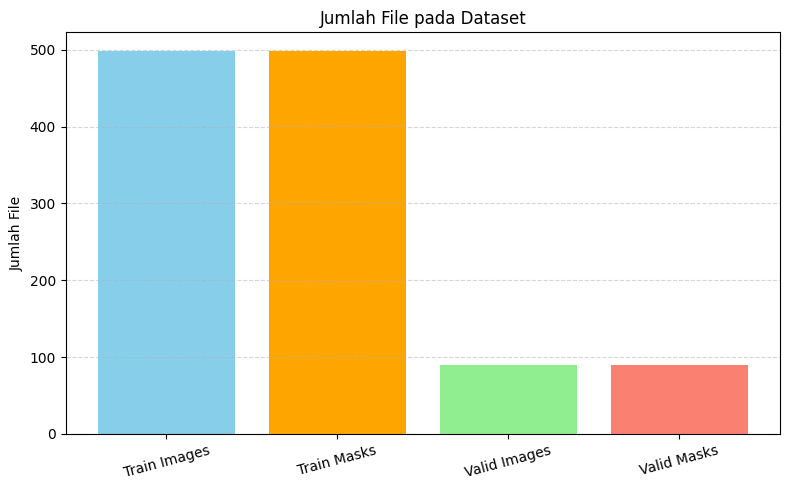

In [3]:
# Hitung jumlah file
train_imgs = len(os.listdir(train_img_path))
train_masks = len(os.listdir(train_mask_path))
valid_imgs = len(os.listdir(valid_img_path))
valid_masks = len(os.listdir(valid_mask_path))

# Print jumlah
print("=== ORIG DATA ===")
print("Train images:", train_imgs)
print("Train masks :", train_masks)
print("Valid images:", valid_imgs)
print("Valid masks :", valid_masks)

# Visualisasi dengan bar chart
labels = ['Train Images', 'Train Masks', 'Valid Images', 'Valid Masks']
values = [train_imgs, train_masks, valid_imgs, valid_masks]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['skyblue', 'orange', 'lightgreen', 'salmon'])
plt.title('Jumlah File pada Dataset')
plt.ylabel('Jumlah File')
plt.xticks(rotation=15)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Pre Processing

In [4]:
def apply_clahe_on_v_channel(hsv_img):
    h, s, v = cv2.split(hsv_img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    v_clahe = clahe.apply(v)
    hsv_clahe = cv2.merge([h, s, v_clahe])
    return hsv_clahe
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv_clahe = apply_clahe_on_v_channel(hsv)  # Tambahan penting
    blurred = cv2.GaussianBlur(hsv_clahe, (5, 5), 0)
    return blurred


## Visualisasi setelah pre processing

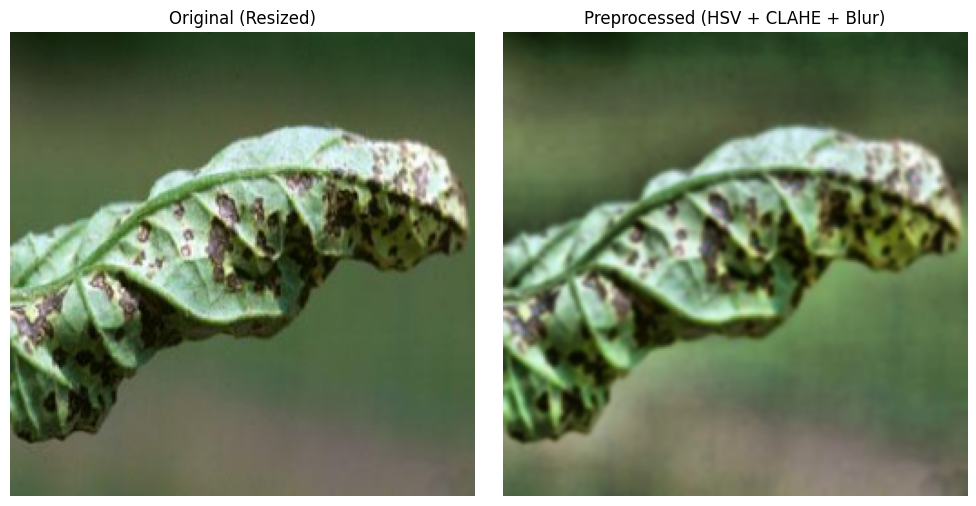

In [5]:
sample_file = os.listdir(train_img_path)[0]
sample_path = os.path.join(train_img_path, sample_file)

# Tampilkan gambar asli dan hasil preprocessing
original = cv2.imread(sample_path)
original_resized = cv2.resize(original, (256, 256))
original_rgb = cv2.cvtColor(original_resized, cv2.COLOR_BGR2RGB)

preprocessed = preprocess_image(sample_path)
preprocessed_rgb = cv2.cvtColor(preprocessed, cv2.COLOR_HSV2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_rgb)
plt.title("Original (Resized)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_rgb)
plt.title("Preprocessed (HSV + CLAHE + Blur)")
plt.axis("off")

plt.tight_layout()
plt.show()

## Simpan semua gambar hasil preprocessing

In [6]:
# Path folder output hasil prepro
processed_train_img_path = os.path.join(base_path, '..', 'processed', 'train_images')

# Buat folder jika belum ada
os.makedirs(processed_train_img_path, exist_ok=True)


In [7]:
# Ambil semua nama file gambar
train_files = os.listdir(train_img_path)

# Loop dan proses semua gambar
for fname in train_files:
    in_path = os.path.join(train_img_path, fname)
    out_path = os.path.join(processed_train_img_path, fname)

    processed_img = preprocess_image(in_path)
    # Konversi HSV kembali ke BGR untuk disimpan
    processed_bgr = cv2.cvtColor(processed_img, cv2.COLOR_HSV2BGR)
    
    cv2.imwrite(out_path, processed_bgr)

print(f"Total gambar train yang diproses dan disimpan: {len(train_files)}")


Total gambar train yang diproses dan disimpan: 498


In [8]:
# Path folder output hasil prepro untuk mask
processed_train_mask_path = os.path.join(base_path, '..', 'processed', 'train_masks')

# Buat folder jika belum ada
os.makedirs(processed_train_mask_path, exist_ok=True)


## Melakukan preprocessing file masks (Resize)

In [9]:
# Ambil semua nama file mask
train_mask_files = os.listdir(train_mask_path)

# Loop dan proses semua mask
for fname in train_mask_files:
    in_path = os.path.join(train_mask_path, fname)
    out_path = os.path.join(processed_train_mask_path, fname)

    # Baca sebagai grayscale
    mask = cv2.imread(in_path, cv2.IMREAD_GRAYSCALE)

    # Resize ke 256x256
    mask_resized = cv2.resize(mask, (256, 256))

    # Simpan hasil ke folder processed
    cv2.imwrite(out_path, mask_resized)

print(f"Total train masks yang diproses dan disimpan: {len(train_mask_files)}")


Total train masks yang diproses dan disimpan: 498


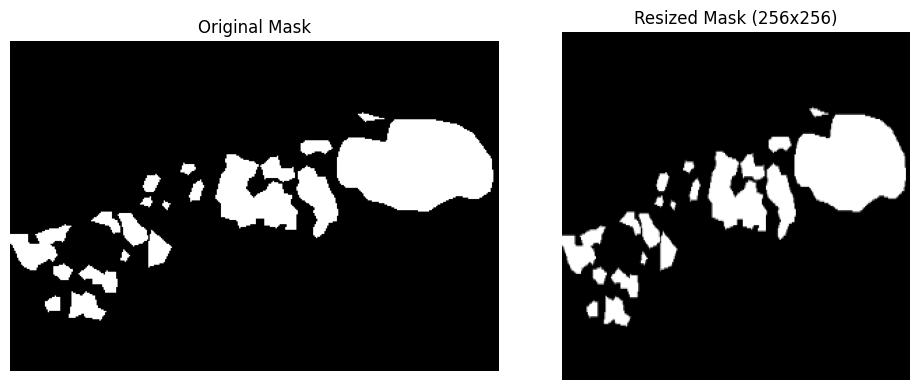

In [10]:
# Contoh nama file mask (ganti sesuai dengan file yang tersedia)
fname = train_mask_files[0]

# Path file sebelum dan sesudah preprocessing
original_mask_path = os.path.join(train_mask_path, fname)
processed_mask_path = os.path.join(processed_train_mask_path, fname)

# Baca kedua gambar mask
original_mask = cv2.imread(original_mask_path, cv2.IMREAD_GRAYSCALE)
processed_mask = cv2.imread(processed_mask_path, cv2.IMREAD_GRAYSCALE)

# Plot hasil perbandingan
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_mask, cmap='gray')
plt.title('Original Mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed_mask, cmap='gray')
plt.title('Resized Mask (256x256)')
plt.axis('off')

plt.tight_layout()
plt.show()

# SEGMENTASI


In [11]:
def segment_leaf_images(input_dir, output_dir, image_size=(256, 256)):
    """
    Melakukan segmentasi daun pada gambar input berdasarkan HSV,
    lalu menyimpan hasil ROI-nya ke folder output.
    
    Parameters:
        input_dir (str): Path folder gambar input (sudah dipreproses).
        output_dir (str): Path folder tempat menyimpan hasil ROI.
        image_size (tuple): Ukuran resize gambar (default: 256x256).
    """
    os.makedirs(output_dir, exist_ok=True)

    for filename in tqdm(os.listdir(input_dir), desc=f"Segmenting images from: {os.path.basename(input_dir)}"):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(input_dir, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.resize(img, image_size)
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

            # Threshold HSV warna penyakit
            lower_hsv = np.array([0, 30, 30])
            upper_hsv = np.array([35, 255, 255])
            mask = cv2.inRange(hsv, lower_hsv, upper_hsv)

            # Operasi morfologi untuk membersihkan noise
            kernel = np.ones((5, 5), np.uint8)
            morph = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel)

            # Simpan hasil segmentasi
            roi_path = os.path.join(output_dir, filename)
            cv2.imwrite(roi_path, morph)

    print(f"📁 Hasil ROI disimpan di: {output_dir}")



In [12]:
segment_leaf_images(
    input_dir=r'C:\Users\owner\latihan\leaf_disease_segmentation\processed\train_images',
    output_dir=r'C:\Users\owner\latihan\leaf_disease_segmentation\processed\ROI\train'
)


Segmenting images from: train_images: 100%|██████████| 498/498 [00:01<00:00, 423.41it/s]

📁 Hasil ROI disimpan di: C:\Users\owner\latihan\leaf_disease_segmentation\processed\ROI\train


# Evaluasi Segmentasi menggunakan Intersection Over Union (IoU) dan Dice Coefficient

In [13]:
def load_binary_mask(path):
    """Membaca gambar mask dan mengkonversi menjadi biner."""
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"File tidak ditemukan atau tidak bisa dibuka: {path}")
    
    # Menentukan threshold berdasarkan intensitas warna
    threshold = 5 if mask.max() <= 50 else 127
    _, binary = cv2.threshold(mask, threshold, 1, cv2.THRESH_BINARY)
    return binary

def calculate_iou(y_true, y_pred):
    """Menghitung Intersection over Union (IoU)."""
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 1.0

def calculate_dice(y_true, y_pred):
    """Menghitung Dice Coefficient."""
    intersection = np.logical_and(y_true, y_pred).sum()
    total = y_true.sum() + y_pred.sum()
    return 2 * intersection / total if total != 0 else 1.0

def evaluate_segmentation(roi_folder, mask_folder):
    """Evaluasi segmentasi gambar daun menggunakan IoU dan Dice Coefficient."""
    ious = []
    dices = []

    for filename in os.listdir(roi_folder):
        if filename.endswith('.jpg'):
            roi_path = os.path.join(roi_folder, filename)

            # Ganti ekstensi dari .jpg -> .png untuk mask
            mask_name = os.path.splitext(filename)[0] + '.png'
            mask_path = os.path.join(mask_folder, mask_name)

            if not os.path.exists(mask_path):
                print(f"[SKIP] Mask tidak ditemukan untuk: {mask_name}")
                continue

            roi_mask = load_binary_mask(roi_path)
            gt_mask = load_binary_mask(mask_path)

            # Resize ground truth jika ukuran berbeda
            if roi_mask.shape != gt_mask.shape:
                gt_mask = cv2.resize(gt_mask, (roi_mask.shape[1], roi_mask.shape[0]))

            # Menghitung IoU dan Dice untuk tiap gambar
            iou = calculate_iou(gt_mask, roi_mask)
            dice = calculate_dice(gt_mask, roi_mask)

            ious.append(iou)
            dices.append(dice)

            # Output per gambar
            print(f"{filename}: IoU={iou:.4f}, Dice={dice:.4f}")

    # Rata-rata hasil evaluasi
    print(f"\nRata-rata IoU: {np.mean(ious):.4f}")
    print(f"Rata-rata Dice: {np.mean(dices):.4f}")




In [14]:
evaluate_segmentation(
    roi_folder = r'C:\Users\owner\latihan\leaf_disease_segmentation\processed\ROI\train',
    mask_folder = train_mask_path
)


00002.jpg: IoU=0.1779, Dice=0.3020
00003.jpg: IoU=0.0001, Dice=0.0003
00004.jpg: IoU=0.4068, Dice=0.5784
00005.jpg: IoU=0.0310, Dice=0.0602
00006.jpg: IoU=0.0080, Dice=0.0158
00008.jpg: IoU=0.3134, Dice=0.4772
00010.jpg: IoU=0.1043, Dice=0.1888
00011.jpg: IoU=0.5873, Dice=0.7400
00012.jpg: IoU=0.4364, Dice=0.6076
00013.jpg: IoU=0.0627, Dice=0.1181
00015.jpg: IoU=0.0153, Dice=0.0301
00016.jpg: IoU=0.0000, Dice=0.0000
00018.jpg: IoU=0.3384, Dice=0.5057
00019.jpg: IoU=0.2855, Dice=0.4442
00020.jpg: IoU=0.0991, Dice=0.1804
00022.jpg: IoU=0.0069, Dice=0.0138
00023.jpg: IoU=0.3849, Dice=0.5558
00024.jpg: IoU=0.0951, Dice=0.1737
00026.jpg: IoU=0.1877, Dice=0.3161
00027.jpg: IoU=0.0969, Dice=0.1766
00029.jpg: IoU=0.7550, Dice=0.8604
00030.jpg: IoU=0.7278, Dice=0.8425
00031.jpg: IoU=0.0124, Dice=0.0244
00032.jpg: IoU=0.0995, Dice=0.1810
00034.jpg: IoU=0.1085, Dice=0.1957
00036.jpg: IoU=0.1016, Dice=0.1844
00037.jpg: IoU=0.7003, Dice=0.8237
00038.jpg: IoU=0.2947, Dice=0.4552
00039.jpg: IoU=0.070

In [15]:
def visual_compare(img_path, roi_path, mask_path):
    # Load data
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    roi = cv2.imread(roi_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Resize semua agar seukuran (jaga-jaga)
    roi = cv2.resize(roi, (img.shape[1], img.shape[0]))
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

    # Buat overlay warna (merah = mask, hijau = ROI)
    overlay = img.copy()
    overlay[mask > 10] = [255, 0, 0]   # red = ground truth
    overlay[roi > 10] = [0, 255, 0]    # green = ROI
    overlay[(roi > 10) & (mask > 10)] = [255, 255, 0]  # yellow = overlap

    # Tampilkan
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.title("Gambar Asli")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(roi, cmap='gray')
    plt.title("Hasil ROI")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask Ground Truth")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(overlay)
    plt.title("Overlay ROI vs Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


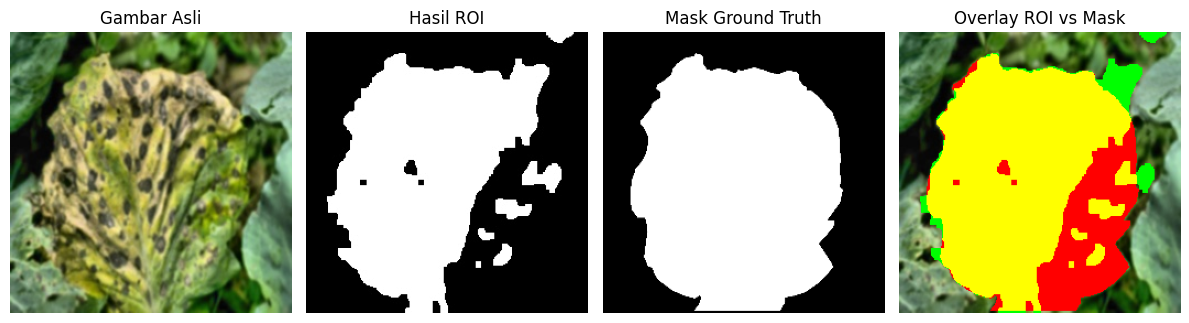

In [16]:
visual_compare(
    img_path='leaf_disease_segmentation/processed/train_images/00030.jpg',
    roi_path='leaf_disease_segmentation/processed/ROI/train/00030.jpg',
    mask_path='leaf_disease_segmentation/processed/train_masks/00030.png'
)

# TEST

In [17]:
valid_input_dir = r'C:\Users\owner\latihan\leaf_disease_segmentation\orig_data\valid_images'
valid_output_dir = r'C:\Users\owner\latihan\leaf_disease_segmentation\processed\valid_images'

os.makedirs(valid_output_dir, exist_ok=True)

for filename in tqdm(os.listdir(valid_input_dir)):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(valid_input_dir, filename)
        processed = preprocess_image(img_path)
        save_path = os.path.join(valid_output_dir, filename)
        cv2.imwrite(save_path, processed)


100%|██████████| 90/90 [00:00<00:00, 110.19it/s]


In [18]:
segment_leaf_images(
    input_dir=r'C:\Users\owner\latihan\leaf_disease_segmentation\processed\valid_images',
    output_dir=r'C:\Users\owner\latihan\leaf_disease_segmentation\processed\ROI\valid'
)


Segmenting images from: valid_images: 100%|██████████| 90/90 [00:00<00:00, 437.41it/s]

📁 Hasil ROI disimpan di: C:\Users\owner\latihan\leaf_disease_segmentation\processed\ROI\valid


In [19]:
evaluate_segmentation(
    roi_folder = r'C:\Users\owner\latihan\leaf_disease_segmentation\processed\ROI\valid',
    mask_folder = valid_mask_path
)


00000.jpg: IoU=0.0240, Dice=0.0468
00001.jpg: IoU=0.0817, Dice=0.1511
00007.jpg: IoU=0.1263, Dice=0.2243
00009.jpg: IoU=0.1267, Dice=0.2249
00014.jpg: IoU=0.4986, Dice=0.6655
00017.jpg: IoU=0.0008, Dice=0.0016
00021.jpg: IoU=0.2189, Dice=0.3592
00025.jpg: IoU=0.0256, Dice=0.0499
00028.jpg: IoU=0.2586, Dice=0.4110
00033.jpg: IoU=0.1554, Dice=0.2690
00035.jpg: IoU=0.0001, Dice=0.0001
00041.jpg: IoU=0.1406, Dice=0.2465
00042.jpg: IoU=0.7265, Dice=0.8416
00049.jpg: IoU=0.0685, Dice=0.1282
00056.jpg: IoU=0.0753, Dice=0.1400
00063.jpg: IoU=0.3349, Dice=0.5018
00070.jpg: IoU=0.0191, Dice=0.0375
00077.jpg: IoU=0.0120, Dice=0.0238
00084.jpg: IoU=0.1282, Dice=0.2272
00091.jpg: IoU=0.2291, Dice=0.3728
00098.jpg: IoU=0.2472, Dice=0.3964
00105.jpg: IoU=0.3270, Dice=0.4929
00112.jpg: IoU=0.0539, Dice=0.1023
00119.jpg: IoU=0.0049, Dice=0.0097
00126.jpg: IoU=0.0589, Dice=0.1113
00133.jpg: IoU=0.0751, Dice=0.1397
00140.jpg: IoU=0.0625, Dice=0.1176
00147.jpg: IoU=0.1959, Dice=0.3276
00154.jpg: IoU=0.424